[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/13_models_with_memory.ipynb)

# Chapter 13 - Models with Memory


## Imports and utility functions


In [1]:
# Install packages that are not installed in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 2.X
    
    !pip install watermark
    !pip install arviz    

In [2]:
%load_ext watermark

In [3]:
from functools import partial

# Core
import numpy as np
import arviz as az
import pandas as pd
import xarray as xr
import tensorflow as tf
import tensorflow_probability as tfp

# visualization 
import matplotlib.pyplot as plt

# aliases
tfd = tfp.distributions
tfb = tfp.bijectors
Root = tfd.JointDistributionCoroutine.Root

In [4]:
%watermark -p numpy,tensorflow,tensorflow_probability,arviz,scipy,pandas

numpy 1.18.1
tensorflow 2.1.0
tensorflow_probability 0.9.0
arviz 0.6.1
scipy 1.4.1
pandas 1.0.1


In [5]:
# config of various plotting libraries
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [6]:
USE_XLA = False

In [7]:
NUMBER_OF_CHAINS  = 2
NUMBER_OF_BURNIN  = 500
NUMBER_OF_SAMPLES = 500
NUMBER_OF_LEAPFROG_STEPS = 4

def _trace_to_arviz(trace=None,
                   sample_stats=None,
                   observed_data=None,
                   prior_predictive=None,
                   posterior_predictive=None,
                   inplace=True):

    if trace is not None and isinstance(trace, dict):
        trace = {k: np.swapaxes(v.numpy(), 1, 0)
                 for k, v in trace.items()}
    if sample_stats is not None and isinstance(sample_stats, dict):
        sample_stats = {k: v.numpy().T for k, v in sample_stats.items()}
    if prior_predictive is not None and isinstance(prior_predictive, dict):
        prior_predictive = {k: v[np.newaxis]
                            for k, v in prior_predictive.items()}
    if posterior_predictive is not None and isinstance(posterior_predictive, dict):
        if isinstance(trace, az.InferenceData) and inplace == True:
            return trace + az.from_dict(posterior_predictive=posterior_predictive)
        else:
            trace = None

    return az.from_dict(
        posterior=trace,
        sample_stats=sample_stats,
        prior_predictive=prior_predictive,
        posterior_predictive=posterior_predictive,
        observed_data=observed_data,
    )

@tf.function(autograph=False, experimental_compile=USE_XLA)
def run_chain(init_state,
              bijectors, 
              step_size, 
              target_log_prob_fn, 
              num_leapfrog_steps=NUMBER_OF_LEAPFROG_STEPS,
              num_samples=NUMBER_OF_SAMPLES,
              burnin=NUMBER_OF_BURNIN,
              ):    

    def _trace_fn_transitioned(_, pkr):
        return (
            pkr.inner_results.inner_results.log_accept_ratio
        )

    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
                    target_log_prob_fn,
                    num_leapfrog_steps=num_leapfrog_steps,
                    step_size=step_size)         

    inner_kernel = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=hmc_kernel,
        bijector=bijectors)       

    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=inner_kernel,
        target_accept_prob=.8,
        num_adaptation_steps=int(0.8*burnin),
        log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio
    )    

    results, sampler_stat = tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=burnin,
        current_state=init_state,
        kernel=kernel,
        trace_fn=_trace_fn_transitioned)

    return results, sampler_stat

def sample_posterior(jdc, 
                      observed_data, 
                      params, 
                      num_chains=NUMBER_OF_CHAINS,
                      init_state=None, 
                      bijectors=None,                              
                      num_samples=NUMBER_OF_SAMPLES, 
                      burnin=NUMBER_OF_BURNIN):       
    
    if init_state is None:
        init_state = list(jdc.sample(NUMBER_OF_CHAINS)[:-1])
        
    if bijectors is None:
        bijectors = [tfb.Identity() for i in init_state]


    target_log_prob_fn = lambda *x: jdc.log_prob(x + observed_data)    
    step_size = 0.1
    results, sample_stats = run_chain(init_state,
                                  bijectors,
                                  step_size=step_size,
                                  target_log_prob_fn=target_log_prob_fn,                                      
                                  num_samples=num_samples, 
                                  burnin=burnin)

    stat_names = ['mean_tree_accept']
    sampler_stats = dict(zip(stat_names, [sample_stats]))    
    posterior = dict(zip(params, results))
    return _trace_to_arviz(trace=posterior, sample_stats=sampler_stats)

## Dataset URL


In [8]:
# You could change base url to local dir or a remoate raw github content
_BASE_URL = "https://raw.githubusercontent.com/ksachdeva/rethinking-tensorflow-probability/master/data"

REEDFROGS_DATASET_PATH = f"{_BASE_URL}/reedfrogs.csv"
CHIMPANZEES_DATASET_PATH = f"{_BASE_URL}/chimpanzees.csv"

## Code 13.1


Reedfrogs dataset is about the tadpole mortality. The objective will be determine the `surv` out of an initial count, `density`.

Author explains that within each tank there are things that go unmeasured and these unmeasured factors create variation in survival across tanks.

These tanks are an example of **cluster** variable

He argues that both of the approaches - 
    * treat the tanks independetly i.e. each of them have their unique intecepts 
    * treat them togather 

have issues. 

for e.g.

    - unique intecepts will imply that we are not using information from other tanks.
    - all togather will have the problem ignoring varations in baseline survival 
    
A multilevel model, in which we simultaneously estimate both an intercept for each tank and the variation among tanks, is what we want !

This type of a model is called **Varying intercepts** model.
        


In [9]:
d = pd.read_csv(REEDFROGS_DATASET_PATH, sep=";")
d.head()

,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9


## Code 13.2

Our simple model. This will give us 48 different intercepts. This means that it does not use the information available between each tank

In [10]:
d["tank"] = np.arange(d.shape[0])
alpha_sample_shape = d["tank"].shape[0]

dat = dict(
    S=tf.cast(d.surv.values, dtype=tf.float32),
    N=tf.cast(d.density.values, dtype=tf.float32),
    tank=d.tank.values)


def model_13_1(tid, N):
    def _generator():      
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=alpha_sample_shape))
      p = tf.sigmoid(tf.squeeze(tf.gather(alpha, tid, axis=-1)))        
        
      S = yield tfd.Independent(tfd.Binomial(total_count=N, probs=p), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_13_1 = model_13_1(dat["tank"], dat["N"])

In [11]:
NUM_CHAINS_FOR_13_1 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_13_1, alpha_sample_shape])
]

bijectors = [
    tfb.Identity()
]

trace_13_1 = sample_posterior(jdc_13_1,
                               observed_data=(dat["S"],),
                               params=['alpha'],
                               num_chains=NUM_CHAINS_FOR_13_1,
                               init_state=init_state,
                               bijectors=bijectors)

az.summary(trace_13_1, round_to=2, kind='all')

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],1.70,0.80,0.33,3.38,0.03,0.03,716.45,501.83,748.29,499.43,1.02
alpha[1],2.41,0.93,0.79,4.22,0.05,0.03,408.44,368.41,420.61,340.22,1.00
alpha[2],0.76,0.63,-0.42,1.81,0.02,0.02,1248.64,625.10,1291.22,485.11,1.02
alpha[3],2.42,0.95,0.81,4.26,0.04,0.03,493.21,474.26,489.12,271.63,1.00
alpha[4],1.70,0.79,0.35,3.35,0.03,0.02,733.71,650.98,745.41,387.37,1.00
alpha[5],1.73,0.80,0.11,3.13,0.03,0.02,606.77,582.69,631.57,179.30,1.00
alpha[6],2.42,0.92,0.72,4.13,0.04,0.03,538.80,452.27,559.31,471.18,1.00
alpha[7],1.71,0.75,0.29,3.05,0.03,0.02,896.57,676.81,907.79,495.87,1.01
alpha[8],-0.35,0.64,-1.56,0.86,0.02,0.02,1224.01,327.22,1224.07,303.10,1.00
alpha[9],1.64,0.71,0.34,2.81,0.03,0.02,629.84,629.84,641.42,227.58,1.00


In [12]:
trace_13_1.sample_stats

<xarray.Dataset>
Dimensions:           (chain: 2, draw: 500)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 493 494 495 496 497 498 499
Data variables:
    mean_tree_accept  (chain, draw) float32 0.30845642 0.3353424 ... 0.04940796
Attributes:
    created_at:  2020-02-17T18:07:22.328789

## Code 13.3

We now build a multilevel model, which adaptively pools information across tanks.

In order to do so, we must make the prior for the parameter **alpha** a function of some new parameters.

Prior itself has priors !


In [13]:
def model_13_2(tid, N):
    def _generator():     
      a_bar = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=1))
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      alpha = yield tfd.Sample(tfd.Normal(loc=a_bar, scale=sigma), sample_shape=alpha_sample_shape)
      p = tf.sigmoid(tf.squeeze(tf.gather(alpha, tid, axis=-1)))              
        
      S = yield tfd.Independent(tfd.Binomial(total_count=N, probs=p), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_13_2 = model_13_2(dat["tank"], dat["N"])

In [14]:
NUM_CHAINS_FOR_13_2 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_13_2]),
    tf.ones([NUM_CHAINS_FOR_13_2]),
    tf.zeros([NUM_CHAINS_FOR_13_2, alpha_sample_shape])
]

bijectors = [
    tfb.Identity(),
    tfb.Exp(),
    tfb.Identity()
]

In [15]:
trace_13_2 = sample_posterior(jdc_13_2,
                           observed_data=(dat["S"],),
                           params=['a_bar', 'sigma', 'alpha'],
                           num_chains=NUM_CHAINS_FOR_13_2, 
                           init_state=init_state,
                           bijectors=bijectors)

az.summary(trace_13_2, round_to=2, kind='all')

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,1.32,0.23,0.91,1.69,0.02,0.01,138.31,121.33,145.51,143.79,1.02
sigma,1.59,0.20,1.19,1.93,0.03,0.02,63.20,63.20,60.60,169.52,1.04
alpha[0],2.03,0.82,0.64,3.64,0.10,0.07,68.30,67.20,69.31,112.49,1.02
alpha[1],2.71,1.11,0.90,4.70,0.28,0.20,15.79,15.79,14.20,40.49,1.12
alpha[2],1.12,0.69,-0.10,2.35,0.06,0.05,117.27,94.70,125.58,140.37,1.03
alpha[3],3.16,1.24,1.34,5.88,0.20,0.15,37.49,36.15,41.64,89.37,1.01
alpha[4],2.22,0.88,0.50,3.72,0.09,0.06,94.13,94.13,99.62,119.03,1.02
alpha[5],2.02,0.77,0.75,3.47,0.07,0.05,118.62,107.17,123.63,143.74,1.03
alpha[6],3.07,1.31,0.91,5.35,0.22,0.17,36.13,30.62,62.54,33.59,1.05
alpha[7],2.04,0.81,0.71,3.63,0.10,0.07,66.06,66.06,56.15,165.92,1.09


## Code 13.4

In [16]:
# we must compute the likelhood before using arviz to do comparison
def compute_and_store_log_likelihood_for_model_13_1(num_chains):

    def log_like_13_1(a):
        p = tf.sigmoid(tf.squeeze(tf.gather(a, dat["tank"], axis=-1)))        
        return tfd.Binomial(total_count=dat["N"], probs=p).log_prob(dat["S"])

    log_likelihood_13_1 = []

    for i in range(num_chains):
        alpha = trace_13_1.posterior["alpha"].values[i]
        log_likelihood = np.array(list(map(log_like_13_1, alpha)))
        log_likelihood_13_1.append(log_likelihood)

    log_likelihood_13_1 = np.array(log_likelihood_13_1)

    # we need to insert this in the sampler_stats
    sample_stats_13_1 = trace_13_1.sample_stats

    coords = [sample_stats_13_1.coords['chain'], sample_stats_13_1.coords['draw'], np.arange(48)]

    sample_stats_13_1["log_likelihood"] = xr.DataArray(
        log_likelihood_13_1, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
compute_and_store_log_likelihood_for_model_13_1(num_chains=2)

In [17]:
def compute_and_store_log_likelihood_for_model_13_2(num_chains):

    def log_like_13_2(a):
        p = tf.sigmoid(tf.squeeze(tf.gather(a, dat["tank"], axis=-1)))        
        return tfd.Binomial(total_count=dat["N"], probs=p).log_prob(dat["S"])

    log_likelihood_13_2 = []

    for i in range(num_chains):
        alpha = trace_13_2.posterior["alpha"].values[i]
        log_likelihood = np.array(list(map(log_like_13_2, alpha)))
        log_likelihood_13_2.append(log_likelihood)

    log_likelihood_13_2 = np.array(log_likelihood_13_2)

    # we need to insert this in the sampler_stats
    sample_stats_13_2 = trace_13_2.sample_stats

    coords = [sample_stats_13_2.coords['chain'], sample_stats_13_2.coords['draw'], np.arange(48)]

    sample_stats_13_2["log_likelihood"] = xr.DataArray(
        log_likelihood_13_2, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
compute_and_store_log_likelihood_for_model_13_2(num_chains=2)

In [18]:
az.compare({"m13.1": trace_13_1, "m13.2": trace_13_2})

/Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m13.2,0,202.044,21.6092,0,0.974089,4.21225,0,True,deviance
m13.1,1,213.538,25.3084,11.4938,0.0259111,7.28963,4.70212,True,deviance


## Code 13.5

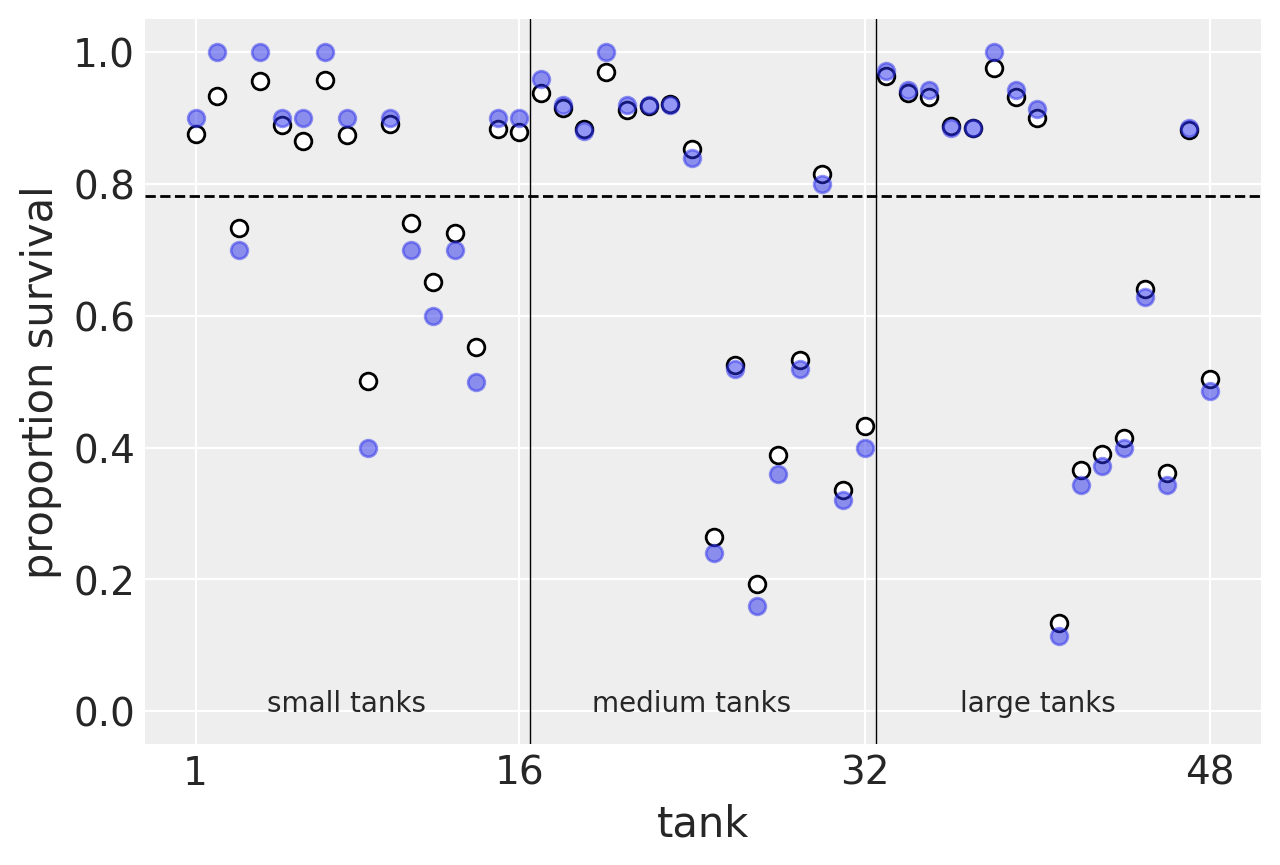

In [19]:
# compute median intercept for each tank
# also transform to probability with logistic

sample_alpha = trace_13_2.posterior["alpha"].values[0]
d["propsurv.est"] = tf.sigmoid(np.mean(sample_alpha, 0)).numpy()

# display raw proportions surviving in each tank
plt.plot(np.arange(1, 49), d.propsurv, "o", alpha=0.5, zorder=3)
plt.gca().set(ylim=(-0.05, 1.05), xlabel="tank", ylabel="proportion survival")
plt.gca().set(xticks=[1, 16, 32, 48], xticklabels=[1, 16, 32, 48])

# overlay posterior means
plt.plot(np.arange(1, 49), d["propsurv.est"], "ko", mfc="w")

sample_a_bar = trace_13_2.posterior["a_bar"].values[0]


# mark posterior mean probability across tanks
plt.gca().axhline(y=tf.reduce_mean(tf.sigmoid(sample_a_bar)).numpy(), c="k", ls="--", lw=1)

# draw vertical dividers between tank densities
plt.gca().axvline(x=16.5, c="k", lw=0.5)
plt.gca().axvline(x=32.5, c="k", lw=0.5)
plt.annotate("small tanks", (8, 0), ha="center")
plt.annotate("medium tanks", (16 + 8, 0), ha="center")
plt.annotate("large tanks", (32 + 8, 0), ha="center");


Here is how to read above plot -

* The dashed line locates the average proportion of survivors across all tanks
* The vertical lines divide tanks with different initial densities of tadpoles: small tanks (10 tad- poles), medium tanks (25), and large tanks (35).
* Empirical proportions of survivors in each tadpole tank, shown by the filled blue points, plotted with the 48 per-tank parameters from the multilevel model, shown by the black circles

In every tank, the posterior mean from the multilevel model is closer to the dashed line than the empir- ical proportion is.

## Code 13.6

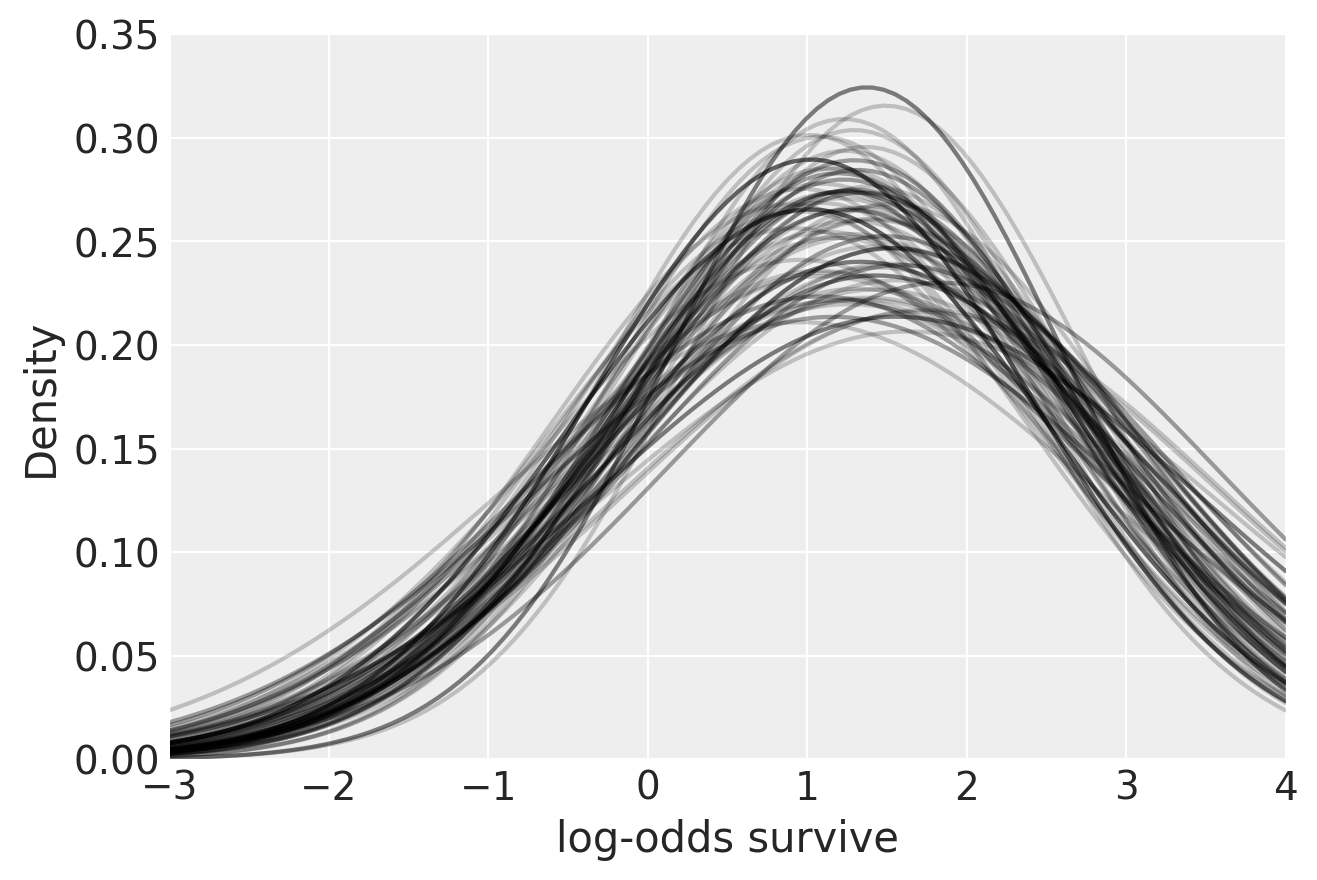

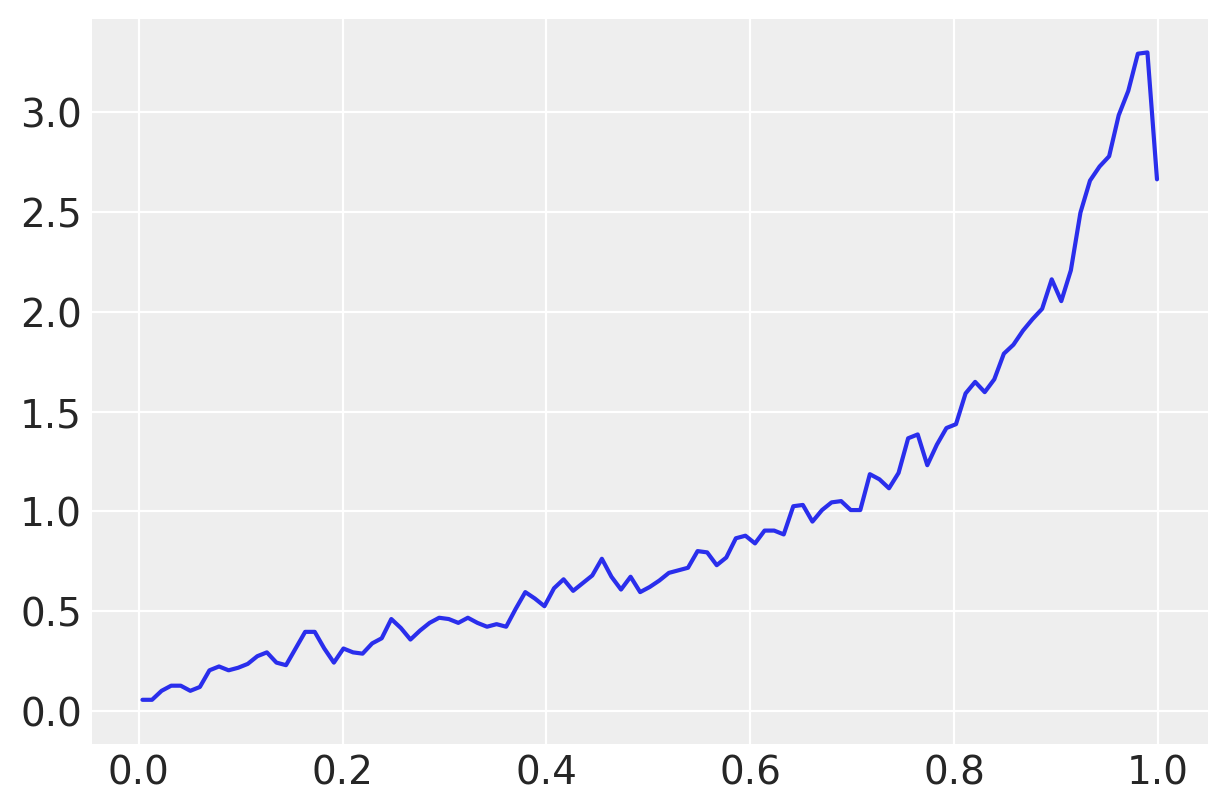

In [20]:
sample_sigma = trace_13_2.posterior["sigma"].values[0]


# show first 100 populations in the posterior
plt.subplot(xlim=(-3, 4), ylim=(0, 0.35),
            xlabel="log-odds survive", ylabel="Density")
for i in range(100):
    x = np.linspace(-3, 4, 101)
    plt.plot(x, tf.exp(tfd.Normal(sample_a_bar[i], sample_sigma[i])
                       .log_prob(x)), "k", alpha=0.2)
plt.show()

# sample 8000 imaginary tanks from the posterior distribution
idxs = np.random.randint(size=(8000,), low=0, high=499)

sim_tanks = tfd.Normal(sample_a_bar[idxs], sample_sigma[idxs]).sample()

# transform to probability and visualize
az.plot_kde(tf.sigmoid(sim_tanks), bw=0.3);

## Code 13.7

In [21]:
a_bar = 1.5
sigma = 1.5
nponds = 60
Ni = np.repeat(np.array([5, 10, 25, 35]), repeats=15)

## Code 13.8

In [22]:
a_pond = tfd.Normal(a_bar, sigma).sample((nponds,))

## Code 13.9

In [23]:
dsim = pd.DataFrame(dict(pond=range(1, nponds + 1), Ni=Ni, true_a=a_pond))

dsim.describe()

,pond,Ni,true_a
count,60.000000,60.000000,60.000000
mean,30.500000,18.750000,1.497430
std,17.464249,12.024868,1.341109
min,1.000000,5.000000,-2.175899
25%,15.750000,8.750000,0.535346
50%,30.500000,17.500000,1.471465
75%,45.250000,27.500000,2.264650
max,60.000000,35.000000,5.519731


## Code 13.10

In [24]:
print(type(range(3)))
print(type(np.arange(3)))

<class 'range'>
<class 'numpy.ndarray'>


## Code 13.11

In [25]:
dsim["Si"] = tfd.Binomial(tf.cast(dsim.Ni.values, dtype=tf.float32), logits=dsim.true_a.values).sample()

## Code 13.12

In [26]:
dsim["p_nopool"] = dsim.Si / dsim.Ni

## Code 13.13

In [27]:
alpha_sample_shape = dsim.pond.shape[0]

In [28]:
dat = dict(
    Si=tf.cast(dsim.Si.values, tf.float32),
    true_a=tf.cast(dsim.true_a.values, tf.float32),
    Ni=tf.cast(dsim.Ni.values, dtype=tf.float32),
    pond=dsim.pond.values - 1
)

In [29]:
def model_13_3(pid, N):
    def _generator():     
      a_bar = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=1))
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      alpha = yield tfd.Sample(tfd.Normal(loc=a_bar, scale=sigma), sample_shape=alpha_sample_shape)
      p = tf.sigmoid(tf.squeeze(tf.gather(alpha, pid, axis=-1)))              
        
      Si = yield tfd.Independent(tfd.Binomial(total_count=N, probs=p), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_13_3 = model_13_3(dat["pond"], dat["Ni"])

In [30]:
NUM_CHAINS_FOR_13_3 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_13_3]),
    tf.ones([NUM_CHAINS_FOR_13_3]),
    tf.zeros([NUM_CHAINS_FOR_13_3, alpha_sample_shape])
]

In [31]:
bijectors = [
    tfb.Identity(),
    tfb.Exp(),
    tfb.Identity()
]

In [32]:
trace_13_3 = sample_posterior(jdc_13_3,
                               observed_data=(dat["Si"],),
                               params=['a_bar', 'sigma', 'alpha'],
                               num_chains=NUM_CHAINS_FOR_13_3, 
                               init_state=init_state,
                               bijectors=bijectors)

## Code 13.14

In [33]:
az.summary(trace_13_3, round_to=2, kind='all')

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,1.38,0.18,1.07,1.76,0.03,0.02,40.97,36.24,41.63,160.74,1.05
sigma,1.33,0.19,0.98,1.67,0.03,0.02,39.55,36.89,49.37,128.96,1.04
alpha[0],1.48,0.85,-0.02,3.26,0.10,0.07,76.13,76.13,76.44,89.32,1.04
alpha[1],1.55,0.89,-0.11,3.23,0.12,0.08,59.21,59.21,66.96,109.42,1.04
alpha[2],0.86,0.84,-0.77,2.28,0.12,0.08,51.94,51.94,56.81,21.44,1.03
...,...,...,...,...,...,...,...,...,...,...,...
alpha[55],2.65,0.56,1.71,3.77,0.05,0.03,135.24,132.67,135.98,263.12,1.01
alpha[56],-0.76,0.35,-1.33,0.04,0.02,0.01,392.97,386.71,391.62,319.31,1.00
alpha[57],0.37,0.35,-0.30,0.98,0.02,0.01,389.66,365.46,391.23,266.30,1.00
alpha[58],0.38,0.36,-0.25,1.02,0.02,0.01,359.17,289.88,371.87,254.83,1.01


## Code 13.15

In [34]:
sample_alpha = trace_13_3.posterior["alpha"].values[0]
dsim["p_partpool"] = tf.reduce_mean(tf.sigmoid(sample_alpha)).numpy()

## Code 13.16

In [35]:
dsim["p_true"] = tf.sigmoid(dsim.true_a.values).numpy()

## Code 13.17

In [36]:
nopool_error = (dsim.p_nopool - dsim.p_true).abs()
partpool_error = (dsim.p_partpool - dsim.p_true).abs()

## Code 13.18

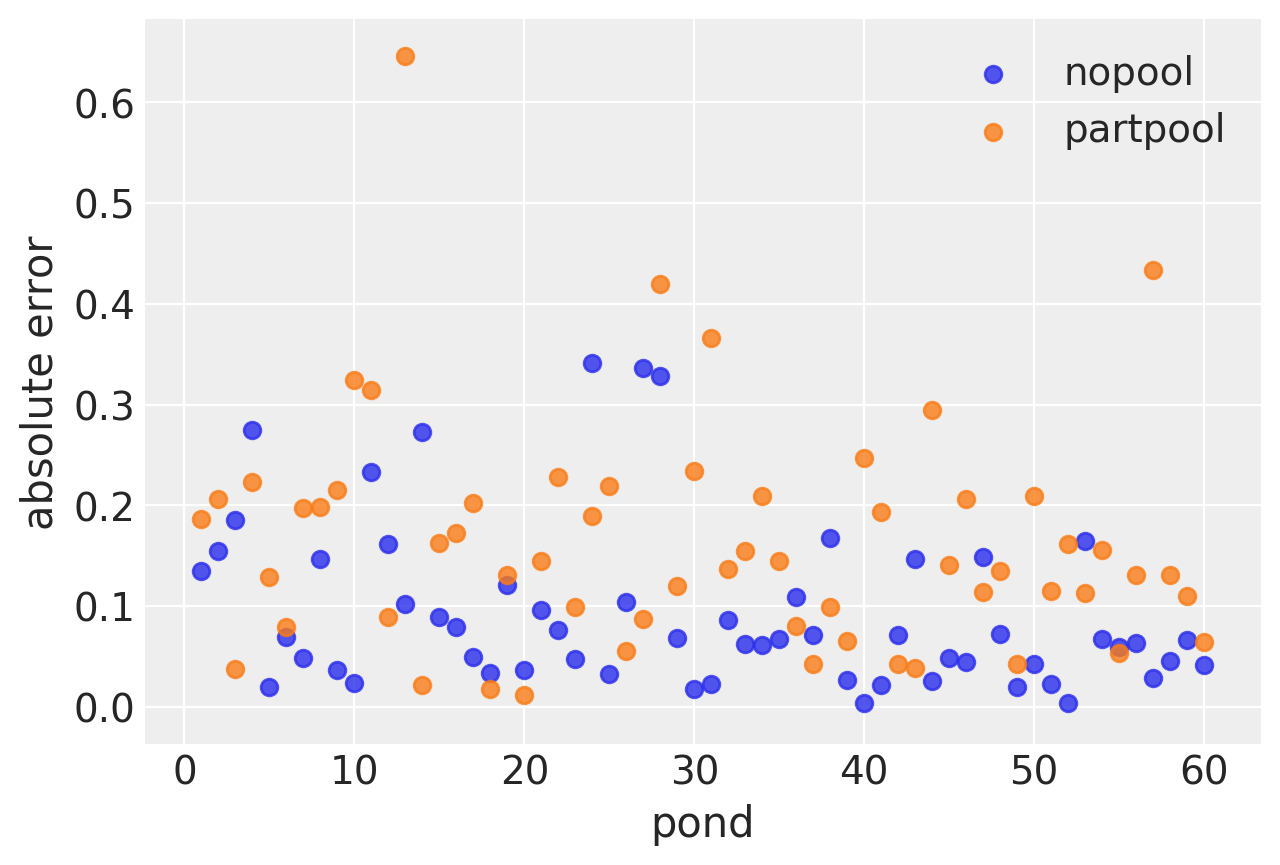

In [37]:
plt.scatter(range(1, 61), nopool_error, label="nopool", alpha=0.8)
plt.gca().set(xlabel="pond", ylabel="absolute error")
plt.scatter(range(1, 61), partpool_error, label="partpool", alpha=0.8)
plt.legend();

## Code 13.19

In [38]:
dsim["nopool_error"] = nopool_error
dsim["partpool_error"] = partpool_error
nopool_avg = dsim.groupby("Ni")["nopool_error"].mean()
partpool_avg = dsim.groupby("Ni")["partpool_error"].mean()

## Code 13.20

In [39]:
a_bar = 1.5
sigma = 1.5
nponds = 60
Ni = np.repeat(np.array([5, 10, 25, 35]), repeats=15)
a_pond = tfd.Normal(a_bar, sigma).sample((nponds,)).numpy()
dsim = pd.DataFrame(dict(pond=range(1, nponds + 1), Ni=Ni, true_a=a_pond))
dsim["Si"] = tfd.Binomial(tf.cast(dsim.Ni.values, dtype=tf.float32), logits=dsim.true_a.values).sample()
dsim["p_nopool"] = dsim.Si / dsim.Ni

newdat = dict(Si=tf.cast(dsim.Si.values, dtype=tf.float32),
              Ni=tf.cast(dsim.Ni.values, dtype=tf.float32),
              pond=dsim.pond.values - 1
)

jdc_13_3new = model_13_3(newdat["pond"], newdat["Ni"])

In [40]:
trace_13_3new = sample_posterior(jdc_13_3new,
                               observed_data=(newdat["Si"],),
                               params=['a_bar', 'sigma', 'alpha'],
                               num_chains=NUM_CHAINS_FOR_13_3, 
                               init_state=init_state,
                               bijectors=bijectors)

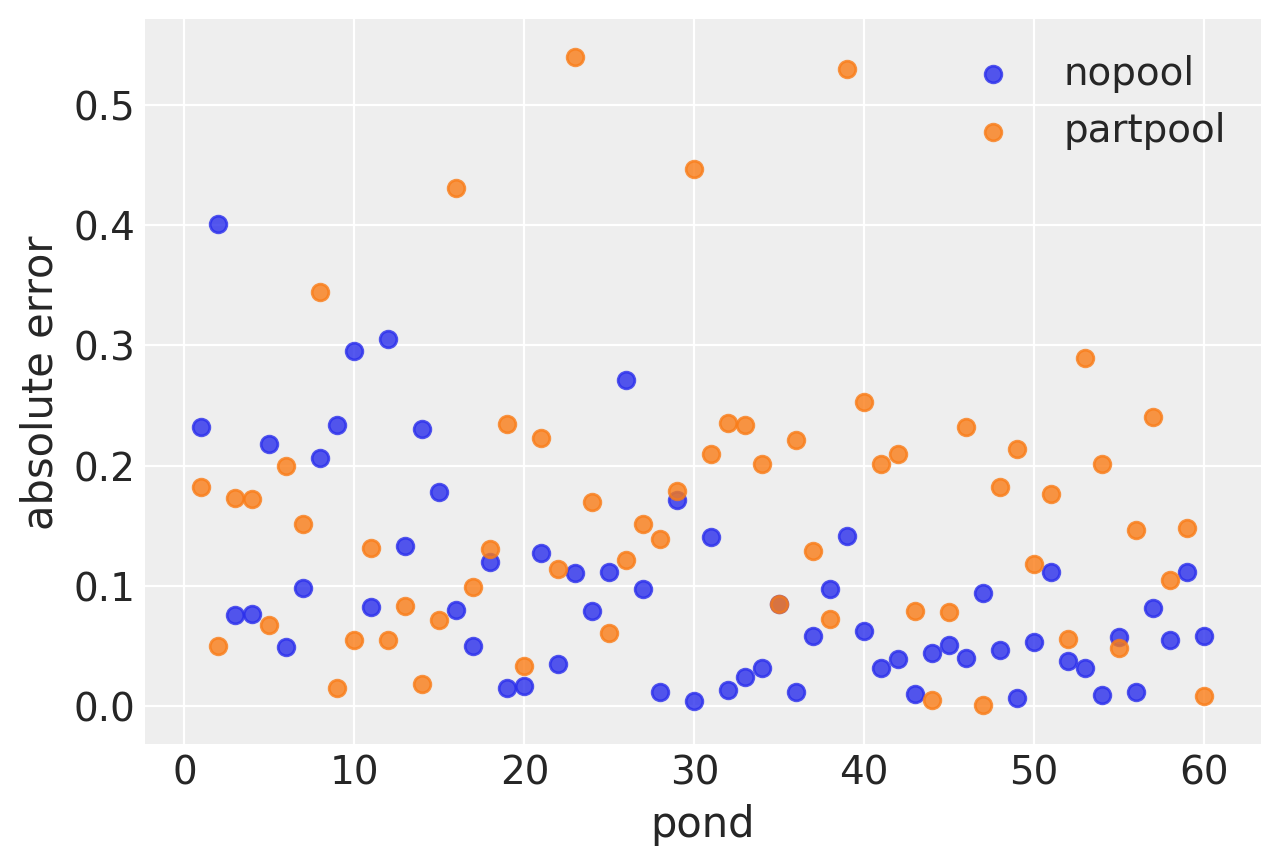

In [41]:
sample_alpha = trace_13_3new.posterior["alpha"].values[0]
dsim["p_partpool"] = tf.reduce_mean(tf.sigmoid(sample_alpha)).numpy()
dsim["p_true"] = tf.sigmoid(dsim.true_a.values).numpy()
nopool_error = (dsim.p_nopool - dsim.p_true).abs()
partpool_error = (dsim.p_partpool - dsim.p_true).abs()
plt.scatter(range(1, 61), nopool_error, label="nopool", alpha=0.8)
plt.gca().set(xlabel="pond", ylabel="absolute error")
plt.scatter(range(1, 61), partpool_error, label="partpool", alpha=0.8)
plt.legend();

## Code 13.21

In [42]:
d = pd.read_csv(CHIMPANZEES_DATASET_PATH, sep=";")
d["treatment"] = 1 + d.prosoc_left + 2 * d.condition

dat = dict(
    pulled_left=tf.cast(d.pulled_left.values, dtype=tf.float32), 
    actor=d.actor.values - 1,
    block_id=d.block.values - 1, 
    treatment=d.treatment.values - 1
)


def model_13_4(actor, block_id, treatment):
    def _generator():  
      # hyper-priors
      a_bar = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=1))
      sigma_a = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      sigma_g = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      # adaptive priors
      alpha = yield tfd.Sample(tfd.Normal(loc=a_bar, scale=sigma_a), sample_shape=7)
      gamma = yield tfd.Sample(tfd.Normal(loc=0., scale=sigma_g), sample_shape=6)  
      beta = yield tfd.Sample(tfd.Normal(loc=0., scale=0.5), sample_shape=4) 
        
      # three terms
      term1 = tf.squeeze(tf.gather(alpha, actor, axis=-1))
      term2 = tf.squeeze(tf.gather(gamma,block_id,axis=-1))
      term3 = tf.squeeze(tf.gather(beta,treatment,axis=-1))
        
      p = tf.sigmoid(term1 + term2 + term3)              
        
      PL = yield tfd.Independent(tfd.Binomial(total_count=1, probs=p), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_13_4 = model_13_4(dat["actor"], dat["block_id"], dat["treatment"])

In [43]:
NUM_CHAINS_FOR_13_4 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_13_4]),
    tf.ones([NUM_CHAINS_FOR_13_4]),
    tf.ones([NUM_CHAINS_FOR_13_4]),
    tf.zeros([NUM_CHAINS_FOR_13_4, 7]),
    tf.zeros([NUM_CHAINS_FOR_13_4, 6]),
    tf.zeros([NUM_CHAINS_FOR_13_4, 4])
]

bijectors = [
    tfb.Identity(),
    tfb.Exp(),
    tfb.Exp(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity()
]

trace_13_4 = sample_posterior(jdc_13_4,
                               observed_data=(dat["pulled_left"],),
                               params=['a_bar', 'sigma_a', 'sigma_g', 'alpha', 'gamma', 'beta'],
                               num_chains=NUM_CHAINS_FOR_13_4, 
                               init_state=init_state,
                               bijectors=bijectors)

## Code 13.22

In [44]:
az.summary(trace_13_4, round_to=2, kind='all')

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,0.80,0.81,-0.50,2.45,0.17,0.12,23.03,23.03,24.31,17.67,1.05
sigma_a,2.23,0.69,1.11,3.75,0.09,0.06,63.72,63.72,32.64,56.03,1.06
sigma_g,0.27,0.16,0.05,0.56,0.03,0.02,34.71,34.71,24.74,24.33,1.06
alpha[0],-0.32,0.36,-1.08,0.30,0.06,0.04,37.65,37.65,38.38,70.56,1.07
alpha[1],5.42,1.25,3.08,7.55,0.58,0.44,4.58,4.58,4.51,28.18,1.37
alpha[2],-0.65,0.38,-1.37,-0.02,0.07,0.05,32.21,32.02,32.89,57.12,1.06
alpha[3],-0.62,0.38,-1.35,0.12,0.08,0.05,25.03,25.03,24.60,70.25,1.09
alpha[4],-0.31,0.36,-1.08,0.27,0.06,0.04,33.60,33.60,34.02,87.58,1.07
alpha[5],0.59,0.39,-0.17,1.26,0.07,0.05,34.94,34.22,35.38,68.64,1.07
alpha[6],2.13,0.44,1.43,3.03,0.10,0.07,21.03,18.65,24.09,80.40,1.08


Note that there is variation across parameters when it comes to effective sample size (ess_mean). This is because some parameters spends a lot of time near a boundary. 

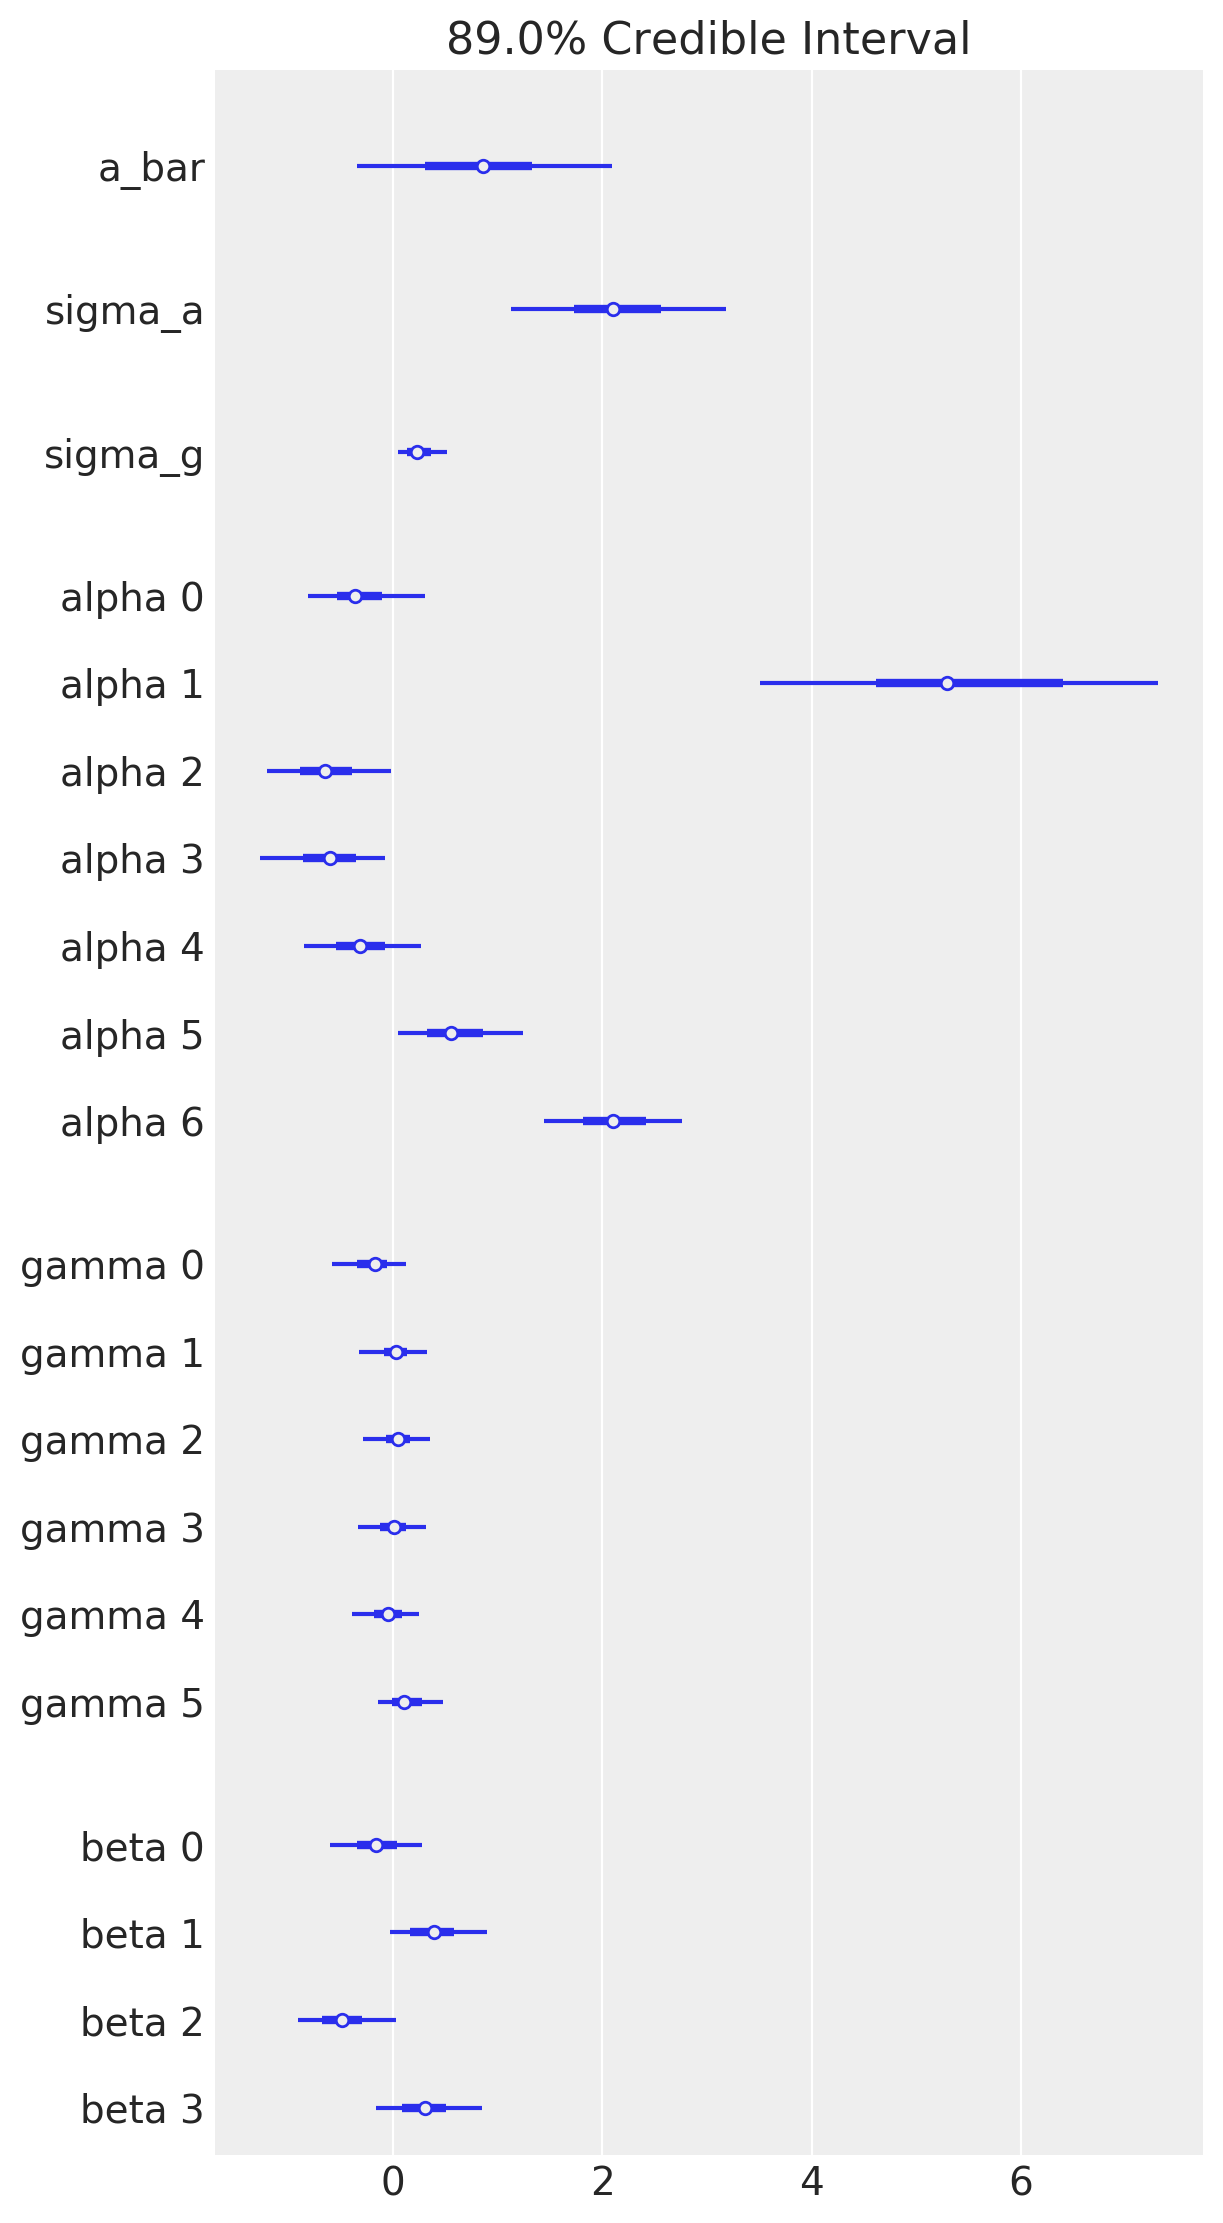

In [45]:
az.plot_forest(trace_13_4, combined=True, credible_interval=0.89); 

## Code 13.23

Build a model that ignores block so that we can then compare it with the above model

In [46]:
def model_13_5(actor, treatment):
    def _generator():  
      # hyper-priors
      a_bar = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=1))
      sigma_a = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      # adaptive priors
      alpha = yield tfd.Sample(tfd.Normal(loc=a_bar, scale=sigma_a), sample_shape=7)
      beta = yield tfd.Sample(tfd.Normal(loc=0., scale=0.5), sample_shape=4) 
        
      # two terms
      term1 = tf.squeeze(tf.gather(alpha, actor, axis=-1))
      term2 = tf.squeeze(tf.gather(beta,treatment,axis=-1))
        
      p = tf.sigmoid(term1 + term2)              
        
      PL = yield tfd.Independent(tfd.Binomial(total_count=1, probs=p), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_13_5 = model_13_5(dat["actor"], dat["treatment"])


NUM_CHAINS_FOR_13_5 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_13_5]),
    tf.ones([NUM_CHAINS_FOR_13_5]),    
    tf.zeros([NUM_CHAINS_FOR_13_5, 7]),
    tf.zeros([NUM_CHAINS_FOR_13_5, 4])
]

bijectors = [
    tfb.Identity(),
    tfb.Exp(),        
    tfb.Identity(),
    tfb.Identity()
]

trace_13_5 = sample_posterior(jdc_13_5,
                               observed_data=(dat["pulled_left"],),
                               params=['a_bar', 'sigma_a', 'alpha', 'beta'],
                               num_chains=NUM_CHAINS_FOR_13_5, 
                               init_state=init_state,
                               bijectors=bijectors)

## Code 13.24

In [47]:
def compute_and_store_log_likelihood_for_model_13_4(num_chains):

    def log_like_13_4(params):
        
        alpha  = params[0]
        gamma  = params[1]
        beta   = params[2]
        
        term1 = tf.squeeze(tf.gather(alpha, dat["actor"], axis=-1))
        term2 = tf.squeeze(tf.gather(gamma,dat["block_id"], axis=-1))
        term3 = tf.squeeze(tf.gather(beta, dat["treatment"] ,axis=-1))        
        
        p = tf.sigmoid(term1 + term2 + term3)                              
        
        return tfd.Binomial(total_count=1, probs=p).log_prob(dat["pulled_left"])

    log_likelihood_13_4 = []

    for i in range(num_chains):
        alpha = trace_13_4.posterior["alpha"].values[i]
        gamma = trace_13_4.posterior["gamma"].values[i]
        beta = trace_13_4.posterior["beta"].values[i]
        log_likelihood = np.array(list(map(log_like_13_4, zip(alpha, gamma, beta))))
        log_likelihood_13_4.append(log_likelihood)

    log_likelihood_13_4 = np.array(log_likelihood_13_4)

    # we need to insert this in the sampler_stats
    sample_stats_13_4 = trace_13_4.sample_stats

    coords = [sample_stats_13_4.coords['chain'], sample_stats_13_4.coords['draw'], np.arange(504)]

    sample_stats_13_4["log_likelihood"] = xr.DataArray(
        log_likelihood_13_4, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
compute_and_store_log_likelihood_for_model_13_4(num_chains=NUM_CHAINS_FOR_13_4)

In [48]:
def compute_and_store_log_likelihood_for_model_13_5(num_chains):

    def log_like_13_5(params):
        
        alpha = params[0]
        beta  = params[1]
        
        term1 = tf.squeeze(tf.gather(alpha, dat["actor"], axis=-1))
        term2 = tf.squeeze(tf.gather(beta, dat["treatment"] ,axis=-1))
        
        p = tf.sigmoid(term1 + term2)                              
        
        return tfd.Binomial(total_count=1, probs=p).log_prob(dat["pulled_left"])

    log_likelihood_13_5 = []

    for i in range(num_chains):
        alpha = trace_13_5.posterior["alpha"].values[i]
        beta = trace_13_5.posterior["beta"].values[i]
        log_likelihood = np.array(list(map(log_like_13_5, zip(alpha,beta))))
        log_likelihood_13_5.append(log_likelihood)

    log_likelihood_13_5 = np.array(log_likelihood_13_5)

    # we need to insert this in the sampler_stats
    sample_stats_13_5 = trace_13_5.sample_stats

    coords = [sample_stats_13_5.coords['chain'], sample_stats_13_5.coords['draw'], np.arange(504)]

    sample_stats_13_5["log_likelihood"] = xr.DataArray(
        log_likelihood_13_5, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
compute_and_store_log_likelihood_for_model_13_5(num_chains=NUM_CHAINS_FOR_13_5)

In [49]:
az.compare({"m13.4": trace_13_4, "m13.5": trace_13_5})

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m13.5,0,531.068,8.35727,0,0.513291,19.14,0,False,deviance
m13.4,1,531.083,10.9303,0.0148555,0.486709,18.8752,2.11823,False,deviance


Above 2 models seem to imply nearly identical predictions. Should we select m13.4 as it is simpler among the two ?. Author here suggests that to select a model, we should rather want to test conditional independencies of different causal models.

## Code 13.25

m13.4 with partial pooling on the treatments

In [50]:
def model_13_6(actor, block_id, treatment):
    def _generator():  
      # hyper-priors
      a_bar = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=1))
      sigma_a = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      sigma_g = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      sigma_b = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))  
      # adaptive priors
      alpha = yield tfd.Sample(tfd.Normal(loc=a_bar, scale=sigma_a), sample_shape=7)
      gamma = yield tfd.Sample(tfd.Normal(loc=0., scale=sigma_g), sample_shape=6)  
      beta = yield tfd.Sample(tfd.Normal(loc=0., scale=sigma_b), sample_shape=4) 
        
      # three terms
      term1 = tf.squeeze(tf.gather(alpha, actor, axis=-1))
      term2 = tf.squeeze(tf.gather(gamma,block_id,axis=-1))
      term3 = tf.squeeze(tf.gather(beta,treatment,axis=-1))
        
      p = tf.sigmoid(term1 + term2 + term3)              
        
      PL = yield tfd.Independent(tfd.Binomial(total_count=1, probs=p), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_13_6 = model_13_6(dat["actor"], dat["block_id"], dat["treatment"])

In [51]:
NUM_CHAINS_FOR_13_6 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_13_6]),
    tf.ones([NUM_CHAINS_FOR_13_6]),
    tf.ones([NUM_CHAINS_FOR_13_6]),
    tf.ones([NUM_CHAINS_FOR_13_6]),
    tf.zeros([NUM_CHAINS_FOR_13_6, 7]),
    tf.zeros([NUM_CHAINS_FOR_13_6, 6]),
    tf.zeros([NUM_CHAINS_FOR_13_6, 4])
]

bijectors = [
    tfb.Identity(),
    tfb.Exp(),
    tfb.Exp(),
    tfb.Exp(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity()
]

trace_13_6 = sample_posterior(jdc_13_6,
                               observed_data=(dat["pulled_left"],),
                               params=['a_bar', 'sigma_a', 'sigma_g', 'sigma_b', 'alpha', 'gamma', 'beta'],
                               num_chains=NUM_CHAINS_FOR_13_6, 
                               init_state=init_state,
                               bijectors=bijectors)

In [52]:
{"m13.4": np.mean(trace_13_4.posterior["beta"].values[1], 0),
 "m13.6": np.mean(trace_13_6.posterior["beta"].values[1], 0)}

{'m13.4': array([-0.0827766 ,  0.43020418, -0.41115293,  0.36836663], dtype=float32),
 'm13.6': array([ 0.01708364,  0.58572036, -0.29625836,  0.46204522], dtype=float32)}

## Code 13.26 (TODO - add notes on divergence) [This code cell is incorrect]

In [53]:
def model_13_7():
    def _generator():  
      v = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=3.), sample_shape=1))
      x = yield tfd.Independent(tfd.Normal(loc=0., scale=tf.exp(v)), reinterpreted_batch_ndims=1)       
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_13_7 = model_13_7()

In [54]:
NUM_CHAINS_FOR_13_7 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_13_7])   
]

bijectors = [    
    tfb.Identity()
]

trace_13_7 = sample_posterior(jdc_13_7,
                               observed_data=(1,),
                               params=['v'],
                               num_chains=NUM_CHAINS_FOR_13_7, 
                               init_state=init_state,
                               bijectors=bijectors)

In [55]:
az.summary(trace_13_7)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v,0.435,0.832,-0.934,2.1,0.038,0.031,469.0,352.0,583.0,332.0,1.01


## Code 13.27 [TODO]

## Code 13.28 [TODO - parameterize the target accept prob]

## Code 13.29

In [56]:
def model_13_4nc(actor, block_id, treatment):
    def _generator():  
      # hyper-priors
      a_bar = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=1))
      sigma_a = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      sigma_g = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      # adaptive priors
      z = yield tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=7)
      x = yield tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=6)  
      b = yield tfd.Sample(tfd.Normal(loc=0., scale=0.5), sample_shape=4) 
        
      # three terms
      term1 = tf.squeeze(tf.gather(z, actor, axis=-1))
      term2 = tf.squeeze(tf.gather(x,block_id,axis=-1))
      term3 = tf.squeeze(tf.gather(b,treatment,axis=-1))        
        
      # reparamertization 
      r = a_bar + term1 * sigma_a + term2 * sigma_g + term3
        
      print("r shape", r.shape)
        
      p = tf.sigmoid(r)              
        
      PL = yield tfd.Independent(tfd.Binomial(total_count=1, probs=p), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_13_4nc = model_13_4nc(dat["actor"], dat["block_id"], dat["treatment"])

In [57]:
s = jdc_13_4nc.sample()

jdc_13_4nc.log_prob(s)

r shape (504,)
r shape (504,)


<tf.Tensor: shape=(), dtype=float32, numpy=-216.17065>

In [58]:
init_state = [
    tf.zeros([NUM_CHAINS_FOR_13_4]),
    tf.ones([NUM_CHAINS_FOR_13_4]),
    tf.ones([NUM_CHAINS_FOR_13_4]),
    tf.zeros([NUM_CHAINS_FOR_13_4, 7]),
    tf.zeros([NUM_CHAINS_FOR_13_4, 6]),
    tf.zeros([NUM_CHAINS_FOR_13_4, 4])
]

bijectors = [
    tfb.Identity(),
    tfb.Exp(),
    tfb.Exp(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity()
]

# TODO - handle shape issues :(

# trace_13_4nc = sample_posterior(jdc_13_4nc,
#                                    observed_data=(dat["pulled_left"],),
#                                    params=['a_bar', 'sigma_a', 'sigma_g', 'z', 'x', 'b'],
#                                    num_chains=NUM_CHAINS_FOR_13_4, 
#                                    init_state=init_state,
#                                    bijectors=bijectors)

## Code 13.30 - 13.39  [TODO after fixing above cell]